# Speech model creation

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

In [3]:
Features = pd.read_csv("../../data/aud_em/mfcc_emo_df.csv")

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['emotion'].values

In [5]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8826, 29), (8826, 6), (2943, 29), (2943, 6))

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8826, 29), (8826, 6), (2943, 29), (2943, 6))

In [8]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((8826, 29, 1), (8826, 6), (2943, 29, 1), (2943, 6))

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-05-01 10:58:56.222185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 10:58:57.617591: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-01 10:58:57.618060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-01 10:58:59.227724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:58:59.228169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-01 10:58:59.228220: I tensorflow/stream_executor/platform/de

In [9]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(29, 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 256)           1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0

2023-05-01 10:59:18.852840: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-01 10:59:18.853080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 10:59:18.853366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-01 10:59:18.853403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 10:59:18.853444: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-05-01 10:59:18.853468: I tensorflow/stream_executor/platform

In [20]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('saved/best_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping, cp])

Epoch 1/100
276/276 [==============================] - 1s 5ms/step - loss: 0.3977 - accuracy: 0.8467 - val_loss: 3.6392 - val_accuracy: 0.4492
Epoch 2/100
276/276 [==============================] - 1s 4ms/step - loss: 0.3882 - accuracy: 0.8479 - val_loss: 3.6952 - val_accuracy: 0.4438
Epoch 3/100
276/276 [==============================] - 1s 4ms/step - loss: 0.3631 - accuracy: 0.8577 - val_loss: 3.9599 - val_accuracy: 0.4438
Epoch 4/100
276/276 [==============================] - 1s 4ms/step - loss: 0.3686 - accuracy: 0.8557 - val_loss: 3.6666 - val_accuracy: 0.4475
Epoch 5/100
276/276 [==============================] - 1s 4ms/step - loss: 0.3655 - accuracy: 0.8559 - val_loss: 3.6979 - val_accuracy: 0.4502
Epoch 6/100
276/276 [==============================] - 1s 4ms/step - loss: 0.3635 - accuracy: 0.8595 - val_loss: 3.7178 - val_accuracy: 0.4533


92/92 [==============================] - 0s 2ms/step - loss: 3.7178 - accuracy: 0.4533
Accuracy of our model on test data :  45.32789587974548 %


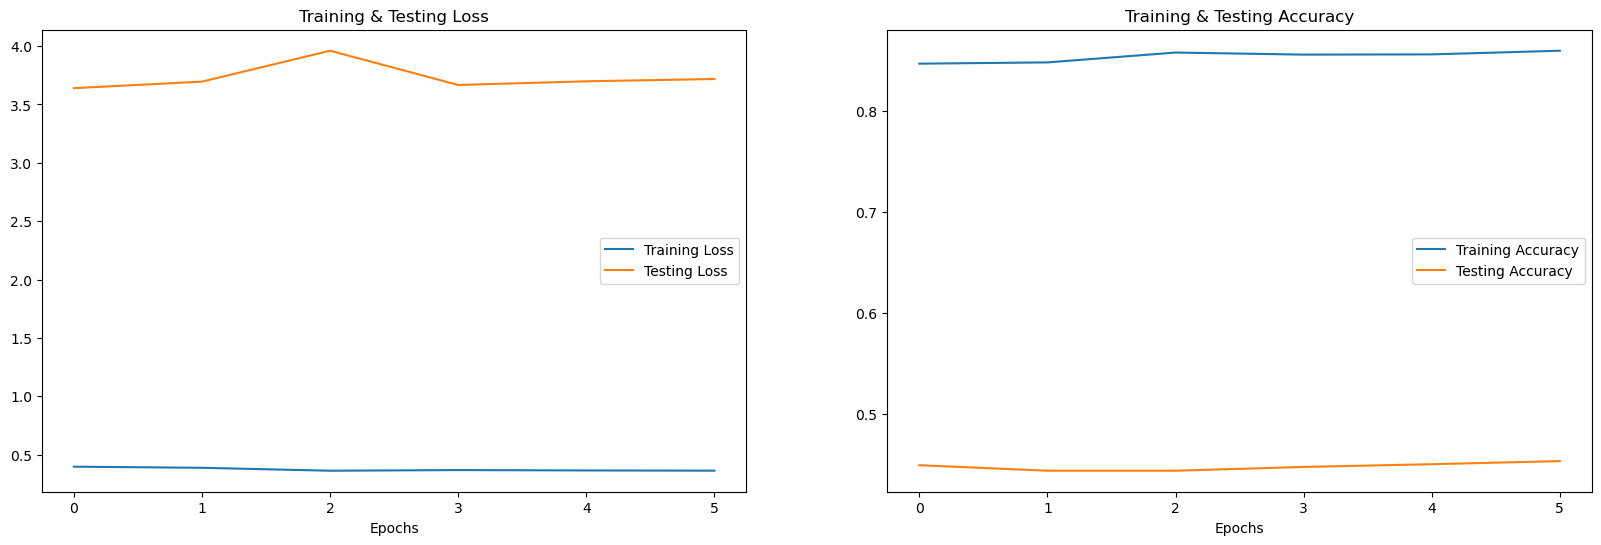

In [21]:
from matplotlib import pyplot as plt

num_epochs = len(history.epoch)

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [22]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [23]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,anger,fear
1,surprise,neutral
2,neutral,neutral
3,anger,anger
4,anger,sadness
5,surprise,surprise
6,neutral,neutral
7,neutral,joy
8,joy,neutral
9,anger,anger


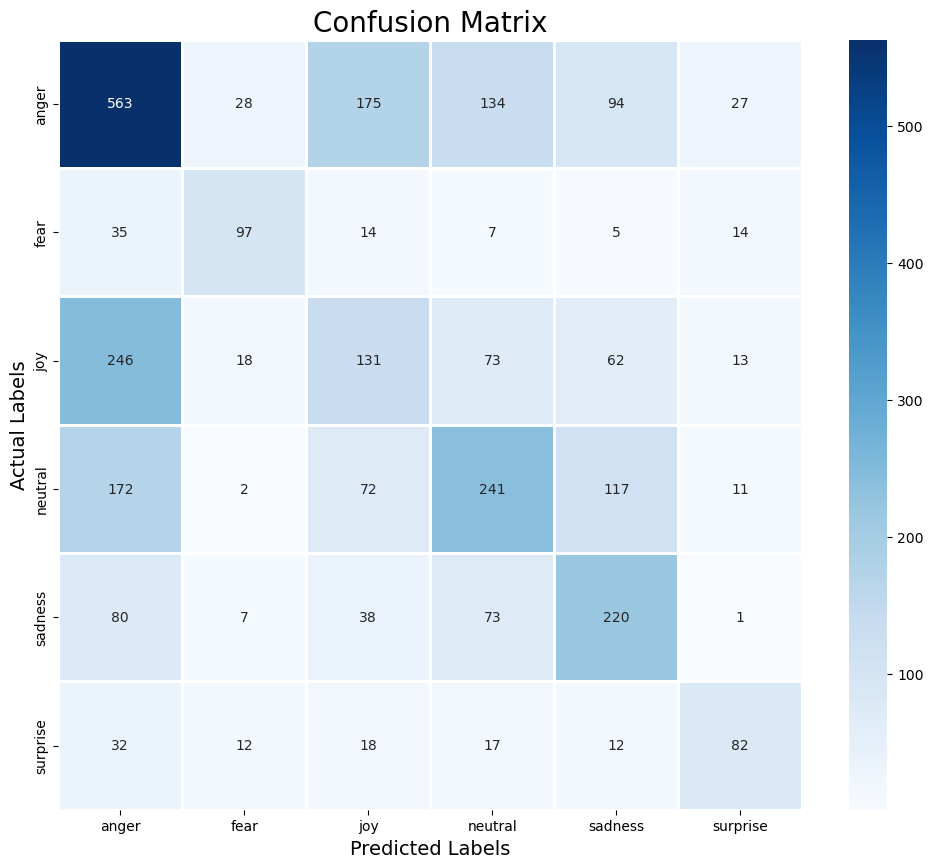

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.50      0.55      0.52      1021
        fear       0.59      0.56      0.58       172
         joy       0.29      0.24      0.26       543
     neutral       0.44      0.39      0.42       615
     sadness       0.43      0.53      0.47       419
    surprise       0.55      0.47      0.51       173

    accuracy                           0.45      2943
   macro avg       0.47      0.46      0.46      2943
weighted avg       0.45      0.45      0.45      2943

